In [56]:
import functools
import itertools

import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from rich.pretty import pprint

from squint.circuit import Circuit
from squint.ops.fock import (
    BeamSplitter,
    FockState,
)
from squint.ops.noise import ErasureChannel
from squint.utils import print_nonzero_entries

In [37]:
n_modes = 1
wires_star = tuple(f"s{i}" for i in range(n_modes))
wires_ancilla = tuple(f"a{i}" for i in range(n_modes))
wires_dump = tuple(f"d{i}" for i in range(n_modes))

circuit = Circuit(backend="mixed")

# # star modes
# circuit.add(
#     TwoModeWeakThermalState(wires=wires_star, epsilon=1.0, g=1.0, phi=0.1), "star"
# )

# ancilla modes
circuit.add(
    FockState(
        wires=wires_ancilla,
        n=[
            (1.0, tuple(1 if i == j else 0 for i in wires_ancilla))
            for j in wires_ancilla
        ],
    )
)

# loss modes
for wire_dump in wires_dump:
    circuit.add(FockState(wires=(wire_dump,)))

for i in range(n_modes):
    circuit.add(
        BeamSplitter(wires=(wires_ancilla[i], wires_dump[i]), r=0.0), f"loss{i}"
    )

# for wire_ancilla, wire_star in zip(wires_ancilla, wires_star):
# circuit.add(BeamSplitter(wires=(wire_ancilla, wire_star)))

for wire_dump in wires_dump:
    circuit.add(ErasureChannel(wires=(wire_dump,)))

pprint(circuit)

Circuit(
  dims=None,
  ops={
│   0:
│   FockState(wires=('a0',), n=[(1.0, (1,))]),
│   1:
│   FockState(wires=('d0',), n=[(1.0, (0,))]),
│   'loss0':
│   BeamSplitter(wires=('a0', 'd0'), r=weak_f64[]),
│   3:
│   ErasureChannel(wires=('d0',))
  },
  _backend='mixed'
)

In [49]:
circuit.verify()

get = lambda pytree: [pytree.op["phase"].phi]
params, static = eqx.partition(circuit, eqx.is_inexact_array)
sim = circuit.compile(circuit, static, dim=3)

In [50]:
print_nonzero_entries(sim.probabilities.forward(params))

Basis: [1], Value: 1.0


In [53]:
rs = jnp.linspace(0, jnp.pi / 2, 50)


def sweep(r, params):
    params = eqx.tree_at(
        lambda pytree: [pytree.ops[f"loss{i}"].r for i in range(n_modes)],
        params,
        [r for i in range(n_modes)],
    )
    return sim.probabilities.forward(params)


probs = jax.lax.map(functools.partial(sweep, params=params), rs)

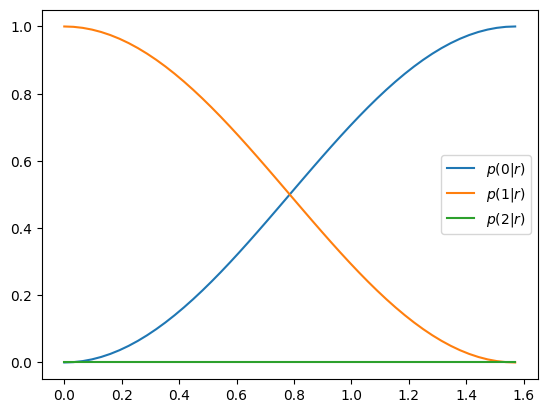

In [61]:
colors = sns.color_palette(n_colors=jnp.prod(jnp.array(probs.shape[1:])))
fig, ax = plt.subplots(ncols=1)
for i, idx in enumerate(
    itertools.product(*[list(range(ell)) for ell in probs.shape[1:]])
):
    ax.plot(
        rs,
        probs[:, *idx],
        label=f"$p({''.join(map(str, idx))}" + r"| r )$",
        color=colors[i],
    )

ax.legend()